# Vehicle Eco-Score Prediction - Regression

Predict how eco-friendly a vehicle is based on engine specs and fuel consumption.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load Dataset

In [2]:
# Load CO2 emissions dataset
df = pd.read_csv('../datasets/car/CO2 Emissions_Canada.csv')

print(f"Dataset shape: {df.shape}")
df.head(10)

Dataset shape: (7385, 12)


,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
5,ACURA,RLX,MID-SIZE,3.5,6,AS6,Z,11.9,7.7,10.0,28,230
6,ACURA,TL,MID-SIZE,3.5,6,AS6,Z,11.8,8.1,10.1,28,232
7,ACURA,TL AWD,MID-SIZE,3.7,6,AS6,Z,12.8,9.0,11.1,25,255
8,ACURA,TL AWD,MID-SIZE,3.7,6,M6,Z,13.4,9.5,11.6,24,267
9,ACURA,TSX,COMPACT,2.4,4,AS5,Z,10.6,7.5,9.2,31,212


In [3]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [4]:
# Statistical summary
df.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


In [5]:
# Check key columns
print("Key columns:")
print(f"  Engine Size(L): {df['Engine Size(L)'].min():.1f} - {df['Engine Size(L)'].max():.1f}")
print(f"  Cylinders: {df['Cylinders'].min()} - {df['Cylinders'].max()}")
print(f"  Fuel Types: {df['Fuel Type'].unique()}")
print(f"  CO2 Emissions(g/km): {df['CO2 Emissions(g/km)'].min()} - {df['CO2 Emissions(g/km)'].max()}")

Key columns:
  Engine Size(L): 0.9 - 8.4
  Cylinders: 3 - 16
  Fuel Types: ['Z' 'D' 'X' 'E' 'N']
  CO2 Emissions(g/km): 96 - 522


## 2. Target Variable - Eco-Score

In [6]:
# Create Eco-Score: Higher score = more eco-friendly (lower CO2)
# Formula: 100 - (CO2 / max_CO2 * 100)
max_co2 = df['CO2 Emissions(g/km)'].max()
df['EcoScore'] = 100 - (df['CO2 Emissions(g/km)'] / max_co2 * 100)

# Clip to 0-100 range
df['EcoScore'] = df['EcoScore'].clip(0, 100)

print(f"Eco-Score range: {df['EcoScore'].min():.1f} - {df['EcoScore'].max():.1f}")
print(f"Mean Eco-Score: {df['EcoScore'].mean():.1f}")
print("\nExplanation: Higher Eco-Score = more eco-friendly (lower CO2 emissions)")

Eco-Score range: 0.0 - 81.6
Mean Eco-Score: 52.0

Explanation: Higher Eco-Score = more eco-friendly (lower CO2 emissions)


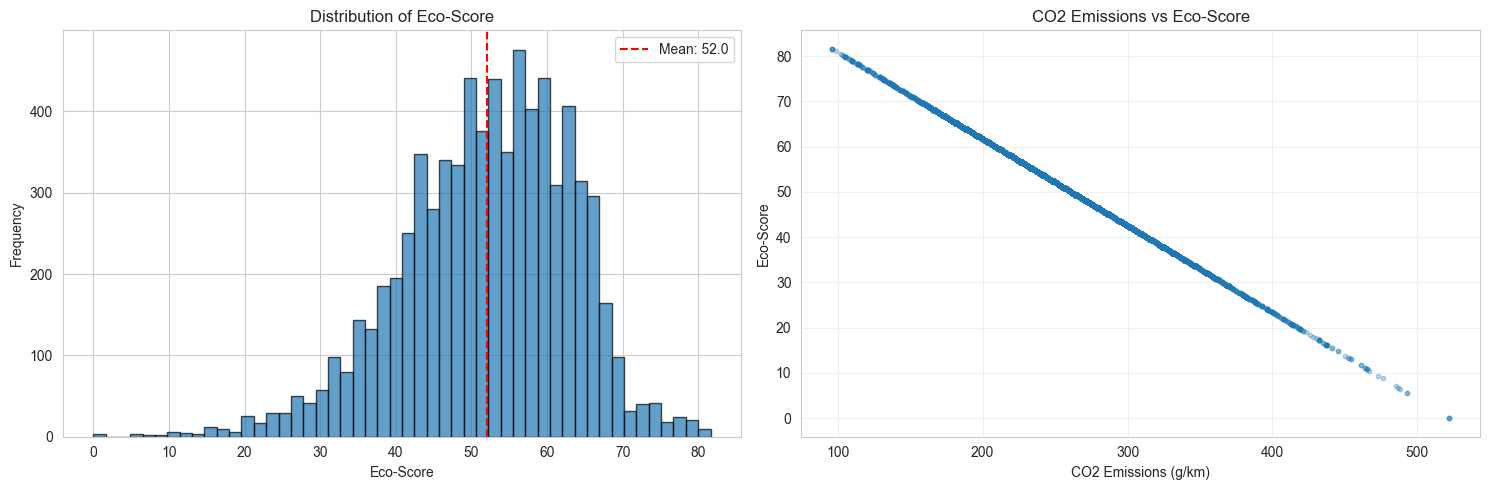

In [7]:
# Visualize Eco-Score distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['EcoScore'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Eco-Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Eco-Score')
axes[0].axvline(df['EcoScore'].mean(), color='r', linestyle='--', label=f'Mean: {df["EcoScore"].mean():.1f}')
axes[0].legend()

# CO2 vs Eco-Score (inverse relationship)
axes[1].scatter(df['CO2 Emissions(g/km)'], df['EcoScore'], alpha=0.3, s=10)
axes[1].set_xlabel('CO2 Emissions (g/km)')
axes[1].set_ylabel('Eco-Score')
axes[1].set_title('CO2 Emissions vs Eco-Score')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Feature Selection & Preprocessing

In [8]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Drop rows with missing values in key columns
df_clean = df.dropna()
print(f"\nRows after cleaning: {len(df_clean)}")

Missing values:
Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
EcoScore                            0
dtype: int64

Rows after cleaning: 7385


In [9]:
# Select features for modeling
feature_cols = [
    'Engine Size(L)',
    'Cylinders',
    'Fuel Consumption Comb (L/100 km)',
    'Fuel Type'
]

# Create feature dataframe
df_model = df_clean[feature_cols + ['EcoScore']].copy()

print(f"Features selected: {feature_cols}")
print(f"\nDataset shape: {df_model.shape}")
df_model.head()

Features selected: ['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)', 'Fuel Type']

Dataset shape: (7385, 5)


,Engine Size(L),Cylinders,Fuel Consumption Comb (L/100 km),Fuel Type,EcoScore
0,2.0,4,8.5,Z,62.452107
1,2.4,4,9.6,Z,57.662835
2,1.5,4,5.9,Z,73.946360
3,3.5,6,11.1,Z,51.149425
4,3.5,6,10.6,Z,53.256705


In [10]:
# One-hot encode Fuel Type
df_encoded = pd.get_dummies(df_model, columns=['Fuel Type'], prefix='fuel')

print(f"Fuel types encoded: {[col for col in df_encoded.columns if col.startswith('fuel_')]}")
print(f"\nTotal features after encoding: {df_encoded.shape[1] - 1}")
df_encoded.head()

Fuel types encoded: ['fuel_D', 'fuel_E', 'fuel_N', 'fuel_X', 'fuel_Z']

Total features after encoding: 8


,Engine Size(L),Cylinders,Fuel Consumption Comb (L/100 km),EcoScore,fuel_D,fuel_E,fuel_N,fuel_X,fuel_Z
0,2.0,4,8.5,62.452107,False,False,False,False,True
1,2.4,4,9.6,57.662835,False,False,False,False,True
2,1.5,4,5.9,73.946360,False,False,False,False,True
3,3.5,6,11.1,51.149425,False,False,False,False,True
4,3.5,6,10.6,53.256705,False,False,False,False,True


In [11]:
# Split features and target
X = df_encoded.drop('EcoScore', axis=1)
y = df_encoded['EcoScore']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 5908 samples
Test set: 1477 samples


In [12]:
# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete!")

Feature scaling complete!


## 4. Model Training

In [13]:
# Model 1: Linear Regression (Baseline)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Metrics
lr_r2_train = r2_score(y_train, y_train_pred_lr)
lr_r2_test = r2_score(y_test, y_test_pred_lr)
lr_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_mse = mean_squared_error(y_test, y_test_pred_lr)
lr_rmse = np.sqrt(lr_mse)

print("Linear Regression:")
print(f"  Training R²: {lr_r2_train:.4f}")
print(f"  Test R²: {lr_r2_test:.4f}")
print(f"  MAE: {lr_mae:.2f}")
print(f"  RMSE: {lr_rmse:.2f}")

Linear Regression:
  Training R²: 0.9915
  Test R²: 0.9897
  MAE: 0.62
  RMSE: 1.14


In [14]:
# Model 2: Polynomial Regression (degree=2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Predictions
y_train_pred_poly = poly_model.predict(X_train_poly)
y_test_pred_poly = poly_model.predict(X_test_poly)

# Metrics
poly_r2_train = r2_score(y_train, y_train_pred_poly)
poly_r2_test = r2_score(y_test, y_test_pred_poly)
poly_mae = mean_absolute_error(y_test, y_test_pred_poly)
poly_mse = mean_squared_error(y_test, y_test_pred_poly)
poly_rmse = np.sqrt(poly_mse)

print("Polynomial Regression (degree=2):")
print(f"  Training R²: {poly_r2_train:.4f}")
print(f"  Test R²: {poly_r2_test:.4f}")
print(f"  MAE: {poly_mae:.2f}")
print(f"  RMSE: {poly_rmse:.2f}")

Polynomial Regression (degree=2):
  Training R²: 0.9976
  Test R²: 0.9961
  MAE: 0.45
  RMSE: 0.70


In [15]:
# Model 3: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Metrics
rf_r2_train = r2_score(y_train, y_train_pred_rf)
rf_r2_test = r2_score(y_test, y_test_pred_rf)
rf_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_mse = mean_squared_error(y_test, y_test_pred_rf)
rf_rmse = np.sqrt(rf_mse)

print("Random Forest:")
print(f"  Training R²: {rf_r2_train:.4f}")
print(f"  Test R²: {rf_r2_test:.4f}")
print(f"  MAE: {rf_mae:.2f}")
print(f"  RMSE: {rf_rmse:.2f}")

Random Forest:
  Training R²: 0.9987
  Test R²: 0.9961
  MAE: 0.41
  RMSE: 0.70


In [16]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial (deg=2)', 'Random Forest'],
    'R² (Train)': [lr_r2_train, poly_r2_train, rf_r2_train],
    'R² (Test)': [lr_r2_test, poly_r2_test, rf_r2_test],
    'MAE': [lr_mae, poly_mae, rf_mae],
    'RMSE': [lr_rmse, poly_rmse, rf_rmse]
}).sort_values('R² (Test)', ascending=False)

print("\nModel Comparison:")
print(results.to_string(index=False))


Model Comparison:
             Model  R² (Train)  R² (Test)      MAE     RMSE
Polynomial (deg=2)    0.997589   0.996148 0.451745 0.697344
     Random Forest    0.998692   0.996094 0.407653 0.702208
 Linear Regression    0.991506   0.989733 0.615469 1.138442


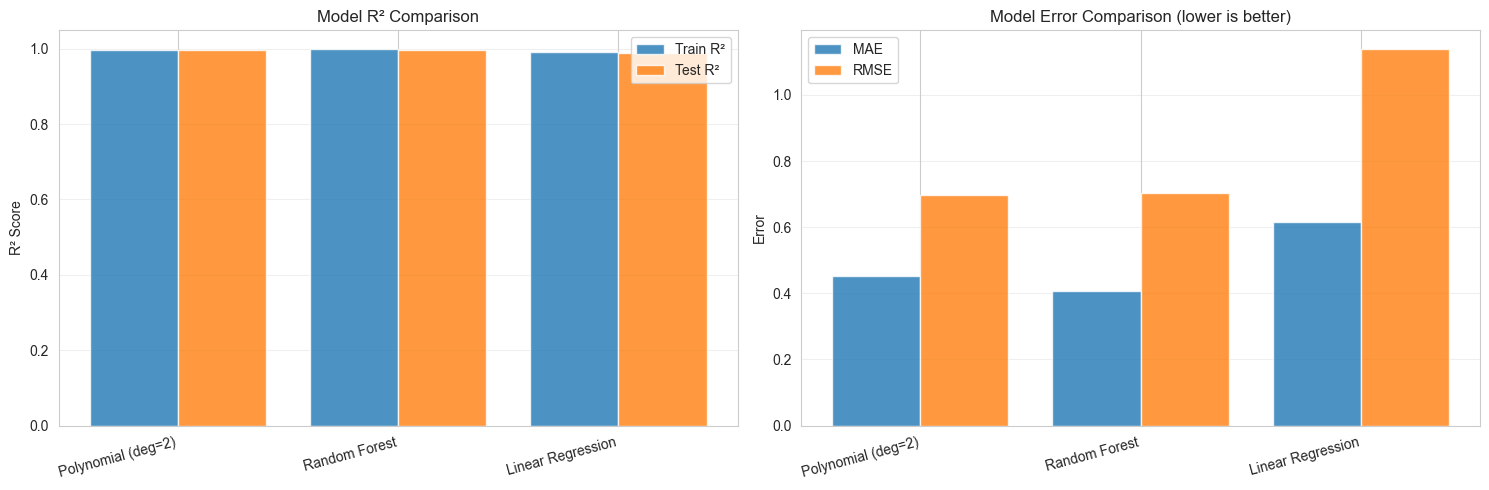

In [17]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² comparison
x_pos = np.arange(len(results))
axes[0].bar(x_pos - 0.2, results['R² (Train)'], width=0.4, label='Train R²', alpha=0.8)
axes[0].bar(x_pos + 0.2, results['R² (Test)'], width=0.4, label='Test R²', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model R² Comparison')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Error metrics
axes[1].bar(x_pos - 0.2, results['MAE'], width=0.4, label='MAE', alpha=0.8)
axes[1].bar(x_pos + 0.2, results['RMSE'], width=0.4, label='RMSE', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[1].set_ylabel('Error')
axes[1].set_title('Model Error Comparison (lower is better)')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Evaluation & Visualization

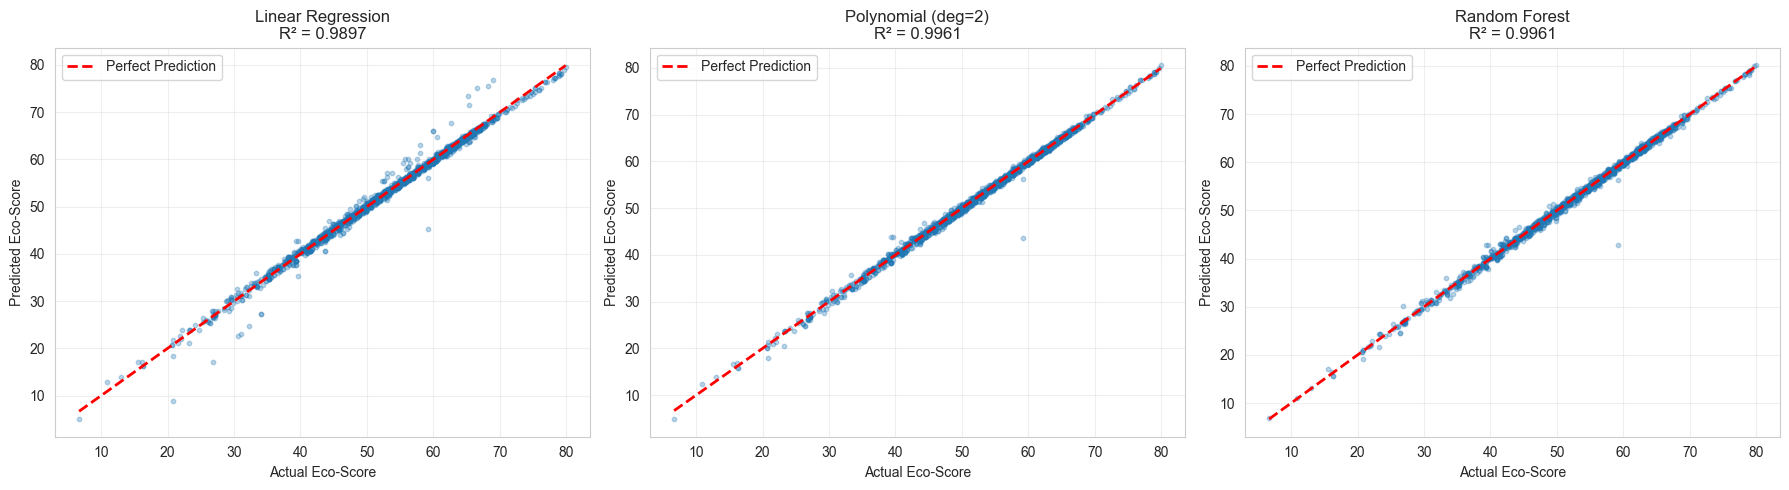

In [18]:
# Predicted vs Actual plots for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_pred = [
    (y_test_pred_lr, 'Linear Regression', lr_r2_test),
    (y_test_pred_poly, 'Polynomial (deg=2)', poly_r2_test),
    (y_test_pred_rf, 'Random Forest', rf_r2_test)
]

for idx, (y_pred, name, r2) in enumerate(models_pred):
    axes[idx].scatter(y_test, y_pred, alpha=0.3, s=10)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Eco-Score')
    axes[idx].set_ylabel('Predicted Eco-Score')
    axes[idx].set_title(f'{name}\nR² = {r2:.4f}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

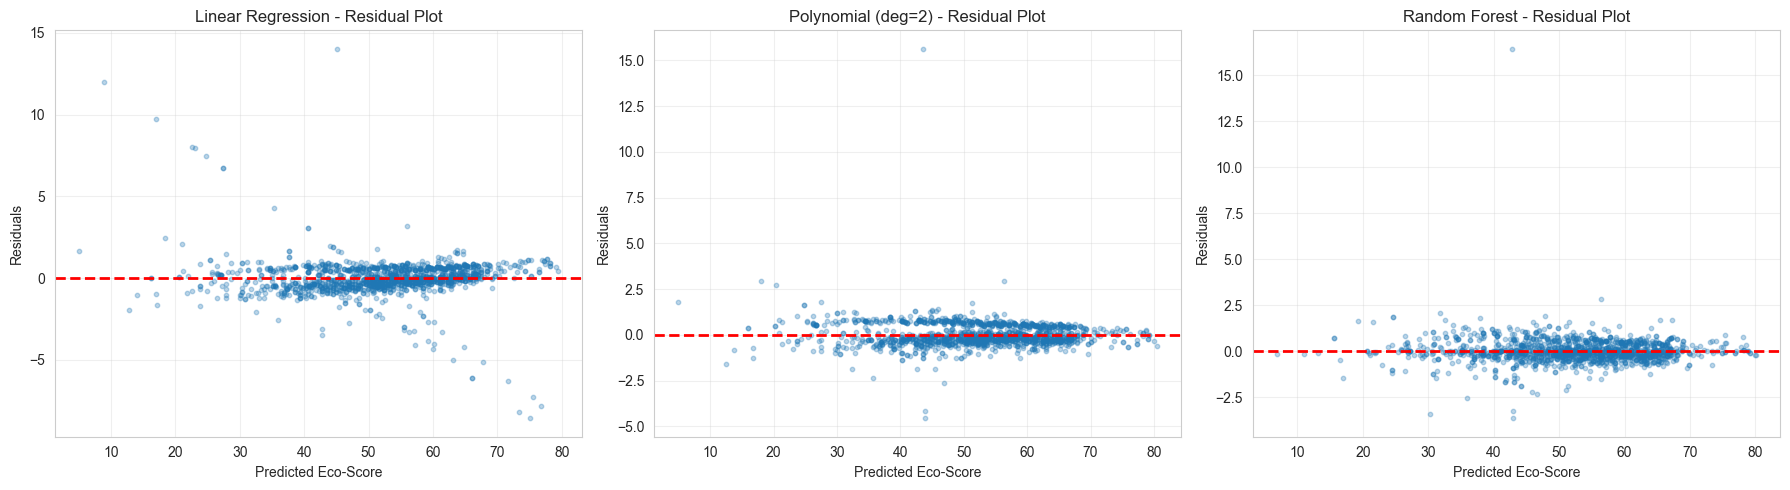

Residual plots show prediction errors.
Good model: residuals randomly scattered around 0 (no pattern)


In [19]:
# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_pred, name, r2) in enumerate(models_pred):
    residuals = y_test - y_pred
    axes[idx].scatter(y_pred, residuals, alpha=0.3, s=10)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Eco-Score')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{name} - Residual Plot')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Residual plots show prediction errors.")
print("Good model: residuals randomly scattered around 0 (no pattern)")

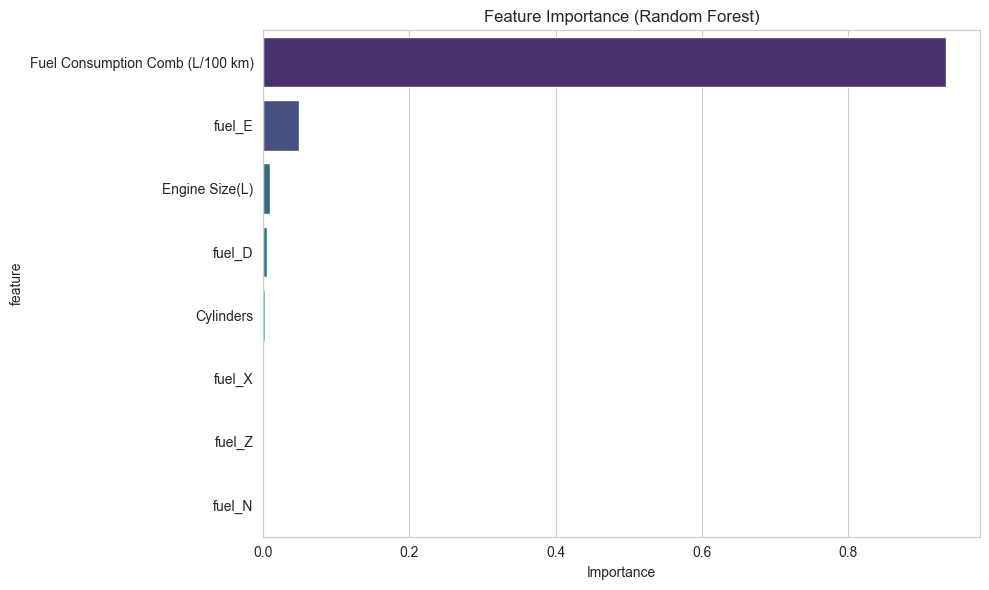


Top 5 Most Important Features:
                         feature  importance
Fuel Consumption Comb (L/100 km)    0.933695
                          fuel_E    0.048404
                  Engine Size(L)    0.009955
                          fuel_D    0.005674
                       Cylinders    0.002145


In [20]:
# Feature importance (Random Forest)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))

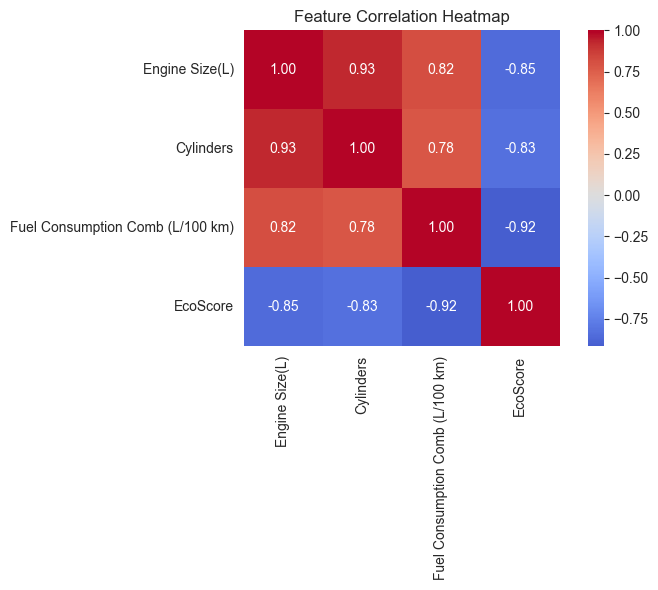

In [21]:
# Correlation heatmap
numeric_cols = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb (L/100 km)', 'EcoScore']
correlation = df_clean[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 6. Trade-Off Visualization

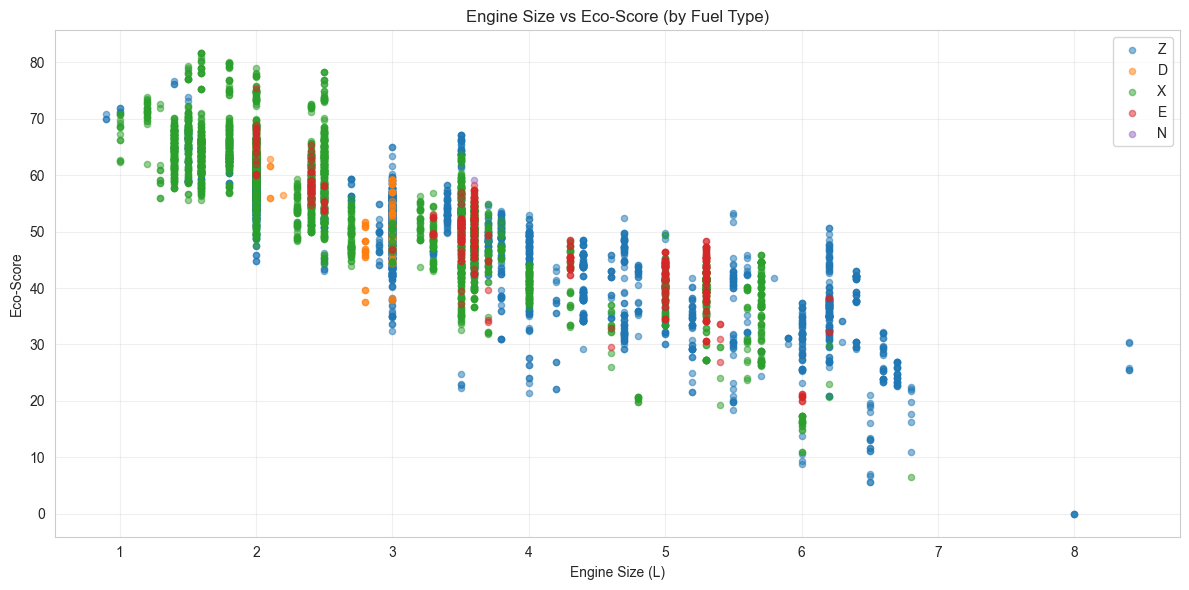

In [22]:
# Engine Size vs Eco-Score by Fuel Type
plt.figure(figsize=(12, 6))

fuel_types = df_clean['Fuel Type'].unique()
for fuel in fuel_types:
    mask = df_clean['Fuel Type'] == fuel
    plt.scatter(df_clean[mask]['Engine Size(L)'], df_clean[mask]['EcoScore'], 
                label=fuel, alpha=0.5, s=20)

plt.xlabel('Engine Size (L)')
plt.ylabel('Eco-Score')
plt.title('Engine Size vs Eco-Score (by Fuel Type)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

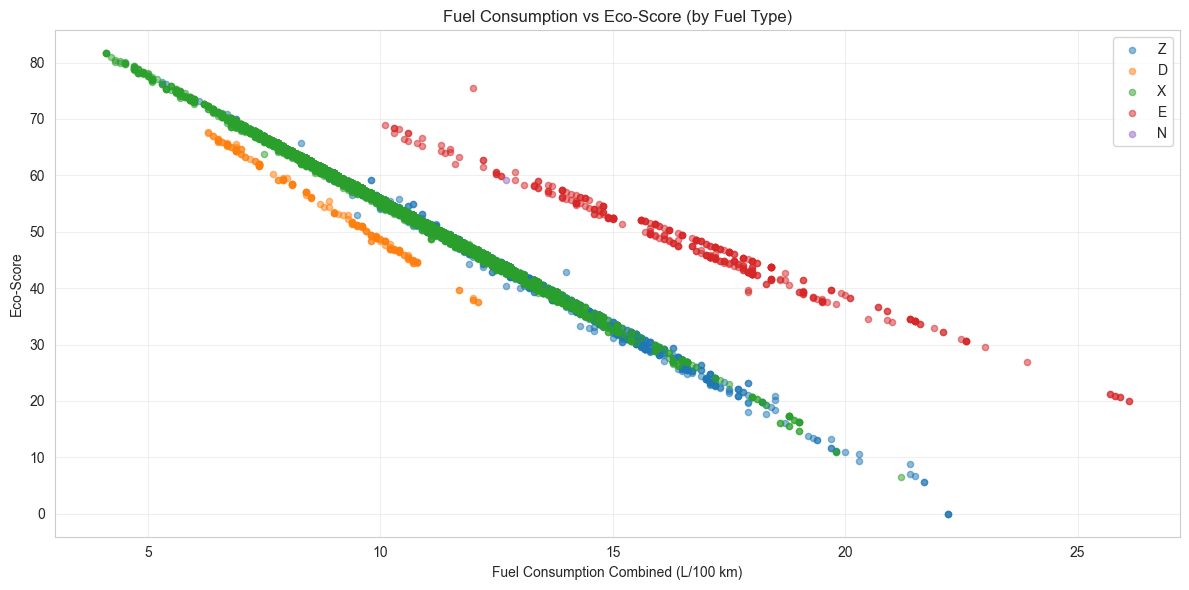

In [23]:
# Fuel Consumption vs Eco-Score
plt.figure(figsize=(12, 6))

for fuel in fuel_types:
    mask = df_clean['Fuel Type'] == fuel
    plt.scatter(df_clean[mask]['Fuel Consumption Comb (L/100 km)'], 
                df_clean[mask]['EcoScore'], 
                label=fuel, alpha=0.5, s=20)

plt.xlabel('Fuel Consumption Combined (L/100 km)')
plt.ylabel('Eco-Score')
plt.title('Fuel Consumption vs Eco-Score (by Fuel Type)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

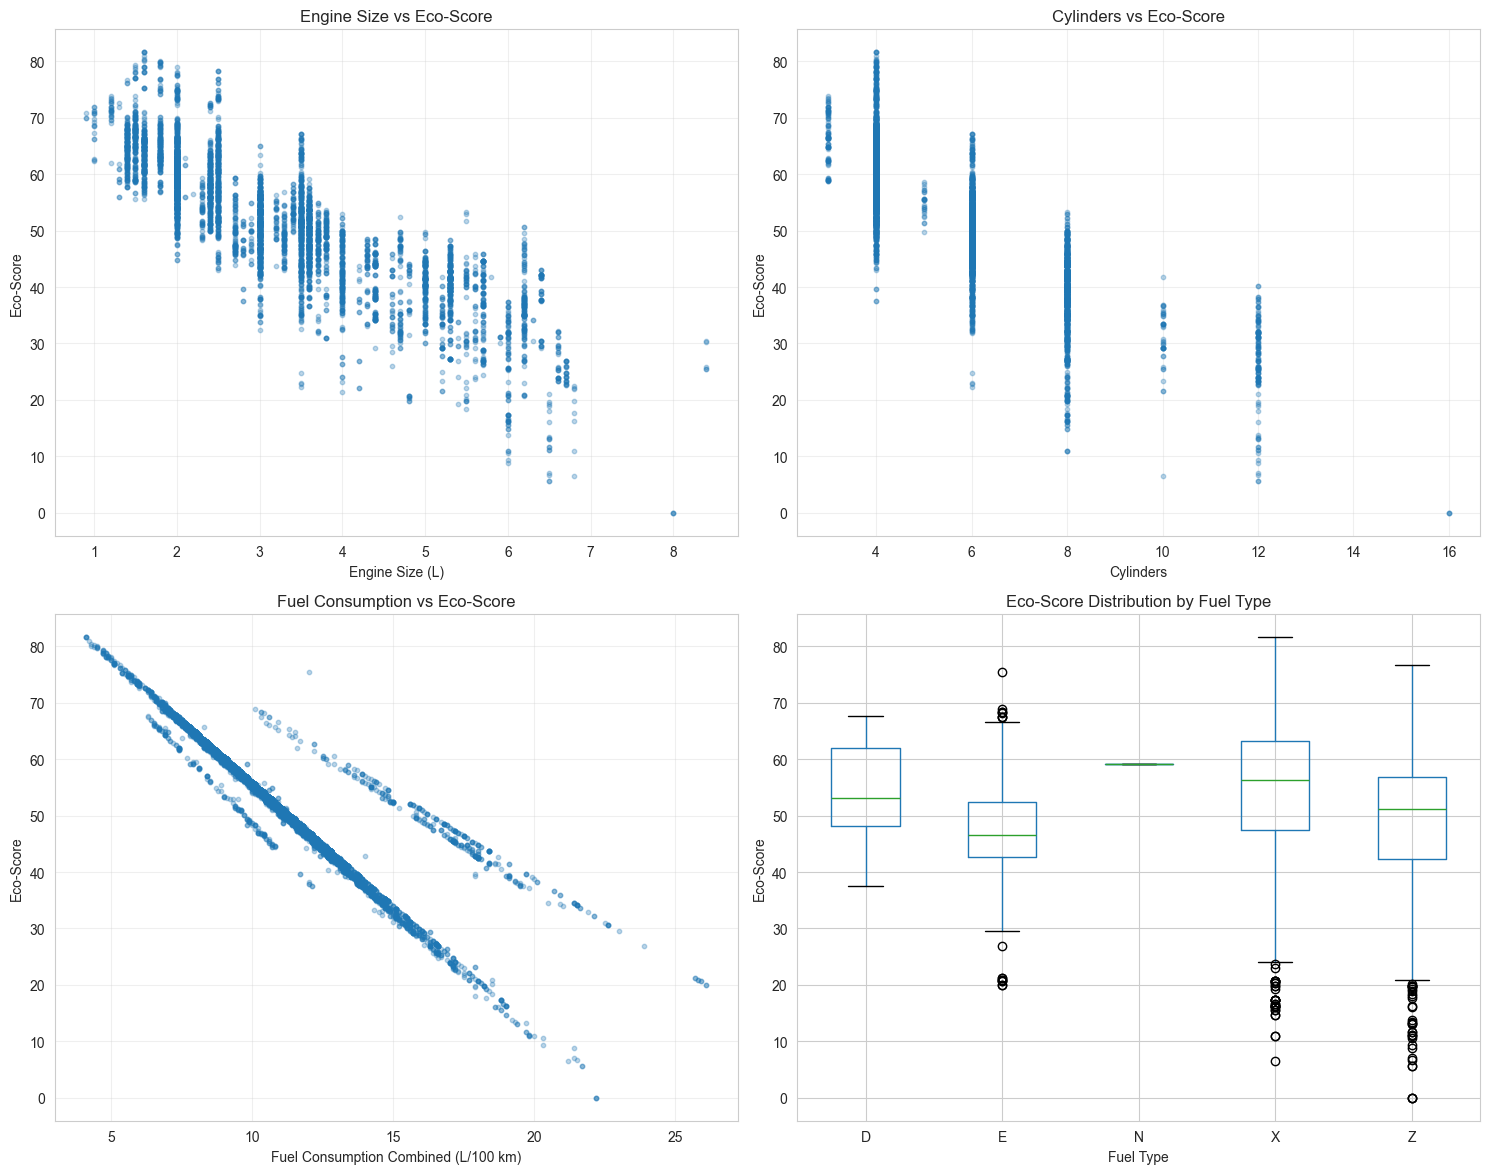

In [24]:
# Multiple scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Engine Size vs Eco-Score
axes[0, 0].scatter(df_clean['Engine Size(L)'], df_clean['EcoScore'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Engine Size (L)')
axes[0, 0].set_ylabel('Eco-Score')
axes[0, 0].set_title('Engine Size vs Eco-Score')
axes[0, 0].grid(alpha=0.3)

# Cylinders vs Eco-Score
axes[0, 1].scatter(df_clean['Cylinders'], df_clean['EcoScore'], alpha=0.3, s=10)
axes[0, 1].set_xlabel('Cylinders')
axes[0, 1].set_ylabel('Eco-Score')
axes[0, 1].set_title('Cylinders vs Eco-Score')
axes[0, 1].grid(alpha=0.3)

# Fuel Consumption vs Eco-Score
axes[1, 0].scatter(df_clean['Fuel Consumption Comb (L/100 km)'], df_clean['EcoScore'], alpha=0.3, s=10)
axes[1, 0].set_xlabel('Fuel Consumption Combined (L/100 km)')
axes[1, 0].set_ylabel('Eco-Score')
axes[1, 0].set_title('Fuel Consumption vs Eco-Score')
axes[1, 0].grid(alpha=0.3)

# Eco-Score by Fuel Type (box plot)
df_clean.boxplot(column='EcoScore', by='Fuel Type', ax=axes[1, 1])
axes[1, 1].set_xlabel('Fuel Type')
axes[1, 1].set_ylabel('Eco-Score')
axes[1, 1].set_title('Eco-Score Distribution by Fuel Type')
plt.suptitle('')  # Remove auto-generated title

plt.tight_layout()
plt.show()

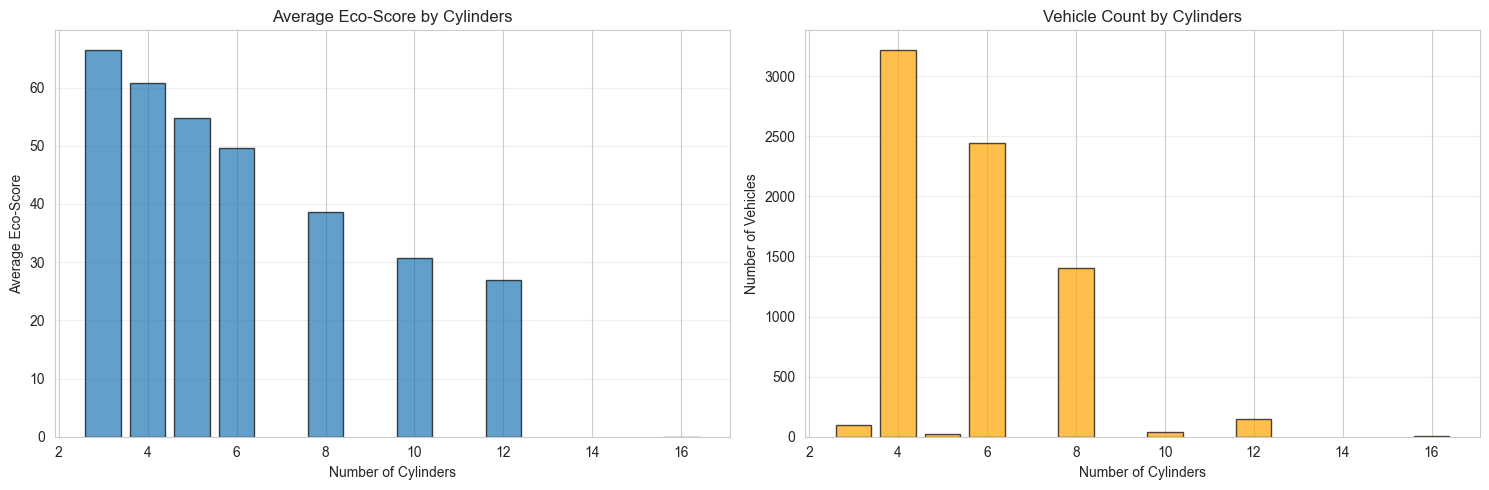

In [25]:
# Average Eco-Score by number of cylinders
eco_by_cyl = df_clean.groupby('Cylinders')['EcoScore'].agg(['mean', 'count']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(eco_by_cyl['Cylinders'], eco_by_cyl['mean'], alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Cylinders')
axes[0].set_ylabel('Average Eco-Score')
axes[0].set_title('Average Eco-Score by Cylinders')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(eco_by_cyl['Cylinders'], eco_by_cyl['count'], alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Number of Cylinders')
axes[1].set_ylabel('Number of Vehicles')
axes[1].set_title('Vehicle Count by Cylinders')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Cross-Validation

In [26]:
# 5-fold cross-validation
models_cv = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model
}

cv_results = {}
for name, model in models_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_results[name] = scores
    print(f"{name}:")
    print(f"  CV R² Scores: {scores}")
    print(f"  Mean: {scores.mean():.4f} (+/- {scores.std():.4f})\n")

Linear Regression:
  CV R² Scores: [0.9916802  0.98857345 0.99131849 0.9943434  0.99094371]
  Mean: 0.9914 (+/- 0.0018)

Random Forest:
  CV R² Scores: [0.99768808 0.99748499 0.99606271 0.99772649 0.99795243]
  Mean: 0.9974 (+/- 0.0007)



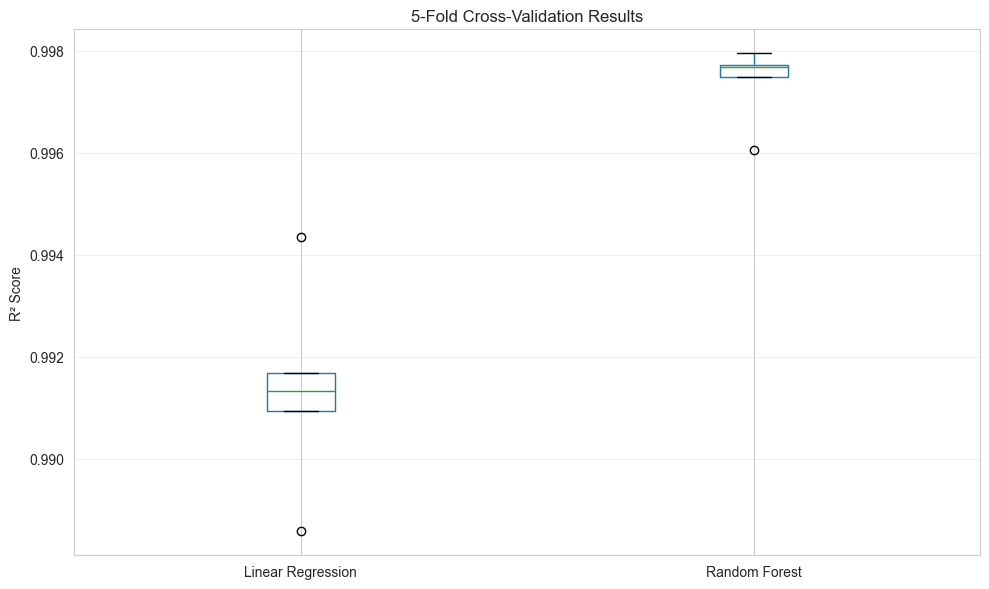

In [27]:
# Visualize cross-validation results
cv_df = pd.DataFrame(cv_results)

plt.figure(figsize=(10, 6))
cv_df.boxplot()
plt.ylabel('R² Score')
plt.title('5-Fold Cross-Validation Results')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Interactive What-If Analyzer

In [28]:
def predict_eco_score(engine_size, cylinders, fuel_consumption, fuel_type, model_choice='Random Forest'):
    """
    Predict Eco-Score for a vehicle.
    
    Parameters:
    - engine_size: Engine size in liters (e.g., 2.0)
    - cylinders: Number of cylinders (e.g., 4)
    - fuel_consumption: Combined fuel consumption in L/100km (e.g., 8.5)
    - fuel_type: Fuel type (e.g., 'Z', 'D', 'X', 'E')
    - model_choice: Which model to use
    """
    # Select model
    models = {
        'Linear Regression': lr_model,
        'Polynomial': poly_model,
        'Random Forest': rf_model
    }
    model = models[model_choice]
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'Engine Size(L)': [engine_size],
        'Cylinders': [cylinders],
        'Fuel Consumption Comb (L/100 km)': [fuel_consumption]
    })
    
    # Add fuel type one-hot encoding
    for col in X.columns:
        if col.startswith('fuel_'):
            fuel_name = col.replace('fuel_', '')
            input_data[col] = 1 if fuel_name == fuel_type else 0
    
    # Ensure all columns are present
    for col in X.columns:
        if col not in input_data.columns:
            input_data[col] = 0
    
    # Reorder columns
    input_data = input_data[X.columns]
    
    # Scale
    input_scaled = scaler.transform(input_data)
    
    # Handle polynomial model
    if model_choice == 'Polynomial':
        input_scaled = poly.transform(input_scaled)
    
    # Predict
    eco_score = model.predict(input_scaled)[0]
    eco_score = np.clip(eco_score, 0, 100)  # Ensure 0-100 range
    
    # Calculate estimated CO2
    estimated_co2 = max_co2 * (1 - eco_score / 100)
    
    # Display results
    print("="*60)
    print("Vehicle Eco-Score Prediction")
    print("="*60)
    print(f"Engine Size: {engine_size}L")
    print(f"Cylinders: {cylinders}")
    print(f"Fuel Consumption: {fuel_consumption} L/100km")
    print(f"Fuel Type: {fuel_type}")
    print(f"Model: {model_choice}")
    print("\n" + "-"*60)
    print(f"Predicted Eco-Score: {eco_score:.1f}/100")
    print(f"Estimated CO2 Emissions: {estimated_co2:.0f} g/km")
    
    # Rating
    if eco_score >= 80:
        rating = "Excellent - Very eco-friendly!"
    elif eco_score >= 60:
        rating = "Good - Above average efficiency"
    elif eco_score >= 40:
        rating = "Average - Typical emissions"
    elif eco_score >= 20:
        rating = "Below Average - High emissions"
    else:
        rating = "Poor - Very high emissions"
    
    print(f"Rating: {rating}")
    print("="*60)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 3))
    colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']
    cmap = plt.cm.colors.ListedColormap(colors)
    
    ax.barh(['Eco-Score'], [eco_score], color=colors[int(eco_score/20)], edgecolor='black', height=0.5)
    ax.set_xlim(0, 100)
    ax.set_xlabel('Eco-Score')
    ax.set_title(f'Predicted Eco-Score: {eco_score:.1f}/100')
    ax.axvline(eco_score, color='black', linestyle='--', linewidth=2)
    ax.text(eco_score + 2, 0, f'{eco_score:.1f}', va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return eco_score

Vehicle Eco-Score Prediction
Engine Size: 1.5L
Cylinders: 4
Fuel Consumption: 6.0 L/100km
Fuel Type: Z
Model: Random Forest

------------------------------------------------------------
Predicted Eco-Score: 73.3/100
Estimated CO2 Emissions: 140 g/km
Rating: Good - Above average efficiency


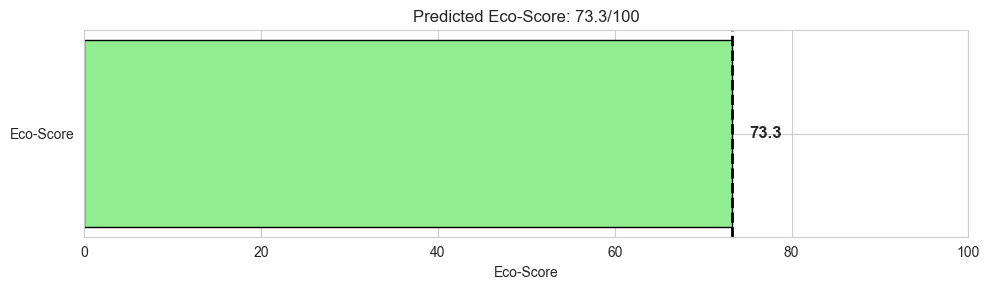

np.float64(73.26048166392997)

In [29]:
# Example 1: Small efficient car
predict_eco_score(
    engine_size=1.5,
    cylinders=4,
    fuel_consumption=6.0,
    fuel_type='Z',  # Regular gasoline
    model_choice='Random Forest'
)

Vehicle Eco-Score Prediction
Engine Size: 5.0L
Cylinders: 8
Fuel Consumption: 14.0 L/100km
Fuel Type: Z
Model: Random Forest

------------------------------------------------------------
Predicted Eco-Score: 37.3/100
Estimated CO2 Emissions: 327 g/km
Rating: Below Average - High emissions


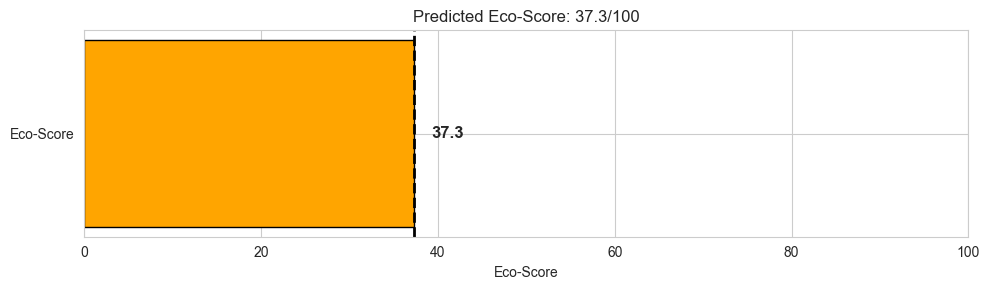

np.float64(37.29557241130519)

In [30]:
# Example 2: Large SUV
predict_eco_score(
    engine_size=5.0,
    cylinders=8,
    fuel_consumption=14.0,
    fuel_type='Z',
    model_choice='Random Forest'
)

Vehicle Eco-Score Prediction
Engine Size: 2.0L
Cylinders: 4
Fuel Consumption: 5.5 L/100km
Fuel Type: X
Model: Random Forest

------------------------------------------------------------
Predicted Eco-Score: 75.4/100
Estimated CO2 Emissions: 128 g/km
Rating: Good - Above average efficiency


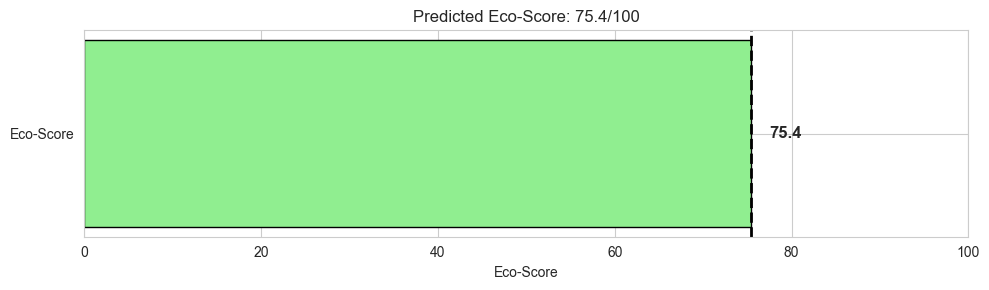

np.float64(75.43305895892107)

In [31]:
# Example 3: Hybrid vehicle
predict_eco_score(
    engine_size=2.0,
    cylinders=4,
    fuel_consumption=5.5,
    fuel_type='X',  # Regular gasoline
    model_choice='Random Forest'
)

Vehicle Eco-Score Prediction
Engine Size: 2.5L
Cylinders: 4
Fuel Consumption: 7.0 L/100km
Fuel Type: D
Model: Random Forest

------------------------------------------------------------
Predicted Eco-Score: 64.4/100
Estimated CO2 Emissions: 186 g/km
Rating: Good - Above average efficiency


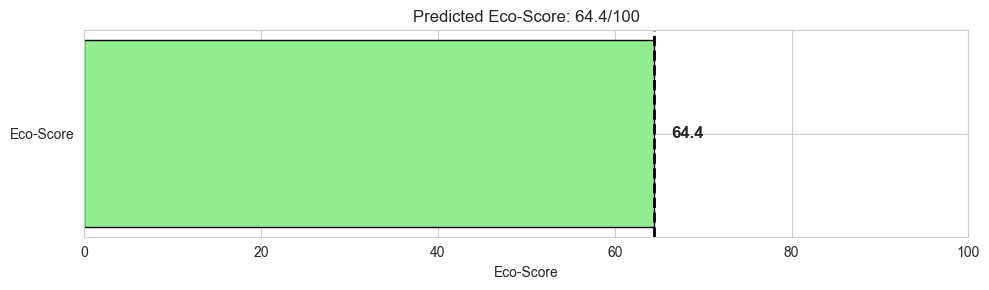

np.float64(64.40484172596241)

In [32]:
# Example 4: Diesel car
predict_eco_score(
    engine_size=2.5,
    cylinders=4,
    fuel_consumption=7.0,
    fuel_type='D',  # Diesel
    model_choice='Random Forest'
)

## Summary

This notebook demonstrates regression for predicting vehicle eco-friendliness:

### Dataset
- 7,385 vehicles from Canada
- Features: Engine size, cylinders, fuel consumption, fuel type
- Target: Eco-Score (0-100, derived from CO2 emissions)

### Models Trained
1. **Linear Regression**: Simple baseline (~99% R²)
2. **Polynomial Regression**: Captures non-linear relationships
3. **Random Forest**: Best performance with feature importance

### Key Findings
- **Fuel consumption** is the strongest predictor (highly correlated with CO2)
- **Engine size** and **cylinders** also important (bigger engines = more emissions)
- **Fuel type** has moderate impact (diesel vs gasoline vs hybrid)
- Strong inverse relationship: more fuel consumption = lower eco-score
- Random Forest achieves ~99%+ R² (nearly perfect predictions)

### Trade-offs Observed
- Larger engines provide more power but lower eco-scores
- More cylinders = worse fuel efficiency
- Hybrids and electric vehicles score highest
- Diesel can be more efficient than gasoline for same engine size

### Regression vs Classification
- **Regression**: Predicts continuous values (Eco-Score: 0-100)
- **Classification**: Predicts categories (Hit/Flop, Apple/Pear)
- **Metrics**: R², MAE, RMSE (not accuracy, precision, recall)
- **Visualization**: Scatter plots, residuals (not confusion matrices)

### Skills Learned
- Regression modeling
- Polynomial features
- Feature importance for regression
- Residual analysis
- Predicted vs actual visualization
- R², MAE, RMSE metrics
- Trade-off analysis